In [1]:
#importing relevant libraries
import numpy as np
import pandas as pd
import math
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image  
from collections import deque

In [2]:
class TreeNode:
    #creating a class TreeNode
    def __init__(self, data,output):
        #To initialize the data members of class TreeNode
        self.data = data
        self.children = {}
        self.output = output
        self.index = -1        
        
    def insert_child(self,feature_value,obj):
        #updating the children dictionary by inserting feature_value as key n obj as value
        self.children[feature_value] = obj

In [8]:
class DTree:
    #creating class DTree
    def __init__(self):
        #To initialize the data members of class DTree
        self.root = None

    def createDict(self,Y):
        #To create a dictionary with keys as unique values of Y and the corresponding value as its frequency
        d = {}
        for key in Y:
            d[key]=d.get(key,0)+1
        return d


    def entropy(self,Y):
        #To calculate the entropy of Y
        dict_Y = self.createDict(Y)
        entropy = 0
        total = len(Y)
        for i in dict_Y:
            p = dict_Y[i]/total
            entropy += (-p)*math.log2(p)
        return entropy

    def gain_ratio(self,X,Y,selected_feature):
        #To calculate the gain ratio of training data on selected_feature
        info_orig = self.entropy(Y) 
        info_f = 0  
        split_info = 0
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0]
        for i in values:
            df_unique = df[df[selected_feature] == i]
            current_size = df_unique.shape[0]
            info_f += (current_size/initial_size)*self.entropy(df_unique[df_unique.shape[1]-1])
            split_info += (-current_size/initial_size)*math.log2(current_size/initial_size)

        #to handle the case when split info = 0 which leads to division by 0 error
        if split_info == 0 :
            return math.inf
        
        info_gain = info_orig - info_f
        gain_ratio = info_gain / split_info
        return gain_ratio

    
    
    def determine_best_split_feature(self,X,Y,features):
        #finding the best feature to split upon
        max_gain = -math.inf
        final_feature = None
        for f in features :
            current_gain = self.gain_ratio(X,Y,f)
        
            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f
        return final_feature,max_gain

    def decision_tree(self,X,Y,features,level,classes):
        #here Nodes are printed as in PREORDER traversal(root,left,right)
        #it split a node on a particular feature only once (in a given root to leaf node path)
        
        if len(set(Y)) == 1:
            print("Level",level)
            output = None
            for i in classes:
                if i in Y:
                    output = i
                    print("Count of",i,"=",len(Y))
                else :
                    print("Count of",i,"=",0)
            print("Current Entropy is =  0.0")
            
            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

        if len(features) == 0:
            print("Level",level)
            dict_Y = self.createDict(Y)
            output = None
            max_count = -math.inf
            for i in classes:
                if i not in dict_Y:
                    print("Count of",i,"=",0)
                else :
                    if dict_Y[i] > max_count :
                        output = i
                        max_count = dict_Y[i]
                    print("Count of",i,"=",dict_Y[i])
            print("Current Entropy  is =",self.entropy(Y))
        
            print("Reached leaf Node")
            print()
            return TreeNode(None,output)
        
        final_feature,max_gain=self.determine_best_split_feature(X,Y,features)
                
        print("Level",level)
        dict_Y = self.createDict(Y)
        output = None
        max_count = -math.inf
        for i in classes:
            if i not in dict_Y:
                print("Count of",i,"=",0)
            else :
                if dict_Y[i] > max_count :
                    output = i
                    max_count = dict_Y[i]
                print("Count of",i,"=",dict_Y[i])
        print("Current Entropy is =",self.entropy(Y))
        print("Splitting on feature  X[",final_feature,"] with gain ratio ",max_gain,sep="")

        #unique_values represents the unique values present in column feature selected of training data  
        unique_values = set(X[:,final_feature]) 
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y

        #current_node represents an instance of class TreeNode with data as final_feature, its output as output, 
        current_node = TreeNode(final_feature,output)
        
        #index represents index of final_feature in list features
        index  = features.index(final_feature)
        features.remove(final_feature)
        
        for i in unique_values:
            #creating a new dataframe with a value of selected feature = i
            df_unique = df[df[final_feature] == i]
            #recursively calling the splits
            node = self.decision_tree(df_unique.iloc[:,0:df_unique.shape[1]-1].values,
                                      df_unique.iloc[:,df_unique.shape[1]-1].values,features,level+1,classes)
            #creating a child node with i as the key and node as value in the children dict
            current_node.insert_child(i,node)    
        features.insert(index,final_feature)

        return current_node
    
    def fit(self,X,Y):
        #To fit the training data into decision tree
        features = [i for i in range(len(X[0]))]
        classes = set(Y)
        level = 0 
        self.root = self.decision_tree(X,Y,features,level,classes)
        
    def predict_tup(self,data,node):
        if len(node.children) == 0 :
            return node.output
        #node.data represents the value of feature on which the split was made
        val = data[node.data]  
        if val not in node.children :
            return node.output
        #recursively calling the splits
        return self.predict_tup(data,node.children[val])

    def predict(self,X):
        #predicting Y values 
        Y=np.array([0 for i in range(len(X))])
        for i in range(len(X)):
            Y[i] = self.predict_tup(X[i],self.root)
        return Y
    
    def score(self,X,Y):        
        #To calculate the mean accuracy
        Y_pred = self.predict(X)
        count = 0
        for i in range(len(Y_pred)):
            if Y_pred[i] == Y[i]:
                count+=1
        return count/len(Y_pred)
    
    def export_tree(self,filename=None):
        #To export tree to pdf
        #initializing dot_data with string
        dot_data = '''digraph Tree {
        node [shape=box] ;'''
        
        #queue represents class deque ie double ended queue
        queue = deque()
        r = self.root
        queue.append(r)
        count = 0
        if r.index == -1:
            r.index = count
            
        dot_data = dot_data + "\n{} [label=\"Split Feature : X[{}]\\nOutput : {}\" ];".format(count,r.data,r.output) 
        
        #doing LEVEL ORDER traversal in the tree (using a queue)
        while len(queue) != 0 :
            node = queue.popleft()
            
            for i in node.children:
                count+=1
                if(node.children[i].index==-1):
                    node.children[i].index = count

                #creating child node
                dot_data = dot_data + "\n{} [label=\"Split Feature : X[{}]\\nOutput : {}\" ];".format(node.children[i].index,node.children[i].data,node.children[i].output) 
                dot_data = dot_data + "\n{} -> {} [ headlabel=\"Split value = {}\"]; ".format(node.index,node.children[i].index,i)
                queue.append(node.children[i])
                                
        dot_data = dot_data + "\n}"
        
        if filename != None:    
            graph = pydotplus.graph_from_dot_data(dot_data)
            graph.write_pdf(filename)    
        
        return dot_data

In [9]:
# 2 input OR GATE
clf1 = DTree()

x = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

y = np.array([0,
              1,
              1,
              1]) 

clf1.fit(x,y)

Level 0
Count of 0 = 1
Count of 1 = 3
Current Entropy is = 0.8112781244591328
Splitting on feature  X[0] with gain ratio 0.31127812445913283
Level 1
Count of 0 = 1
Count of 1 = 1
Current Entropy is = 1.0
Splitting on feature  X[1] with gain ratio 1.0
Level 2
Count of 0 = 1
Count of 1 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 2
Current Entropy is =  0.0
Reached leaf Node



In [10]:
Y_pred = clf1.predict(x)
print("Predictions :",Y_pred)
print()
our_score=clf1.score(x,y)
print("Score :",our_score) 
print()

Predictions : [0 1 1 1]

Score : 1.0



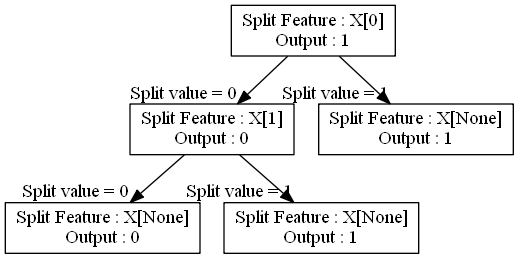

In [11]:
dot_data=clf1.export_tree(filename="tree_OR.pdf")
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
# Using the inbuilt sklearn Decision tree and comparing it with our model on the same dataset
import sklearn.tree
clf2 = sklearn.tree.DecisionTreeClassifier()
clf2.fit(x,y)
Y_pred2 = clf2.predict(x)
print("Predictions",Y_pred2)
sklearn_score = clf2.score(x,y)

#comparing scores
print("Score of our model :",our_score)
print("Score of inbuilt sklearn's decision tree on the same data :",sklearn_score)

Predictions [0 1 1 1]
Score of our model : 1.0
Score of inbuilt sklearn's decision tree on the same data : 1.0


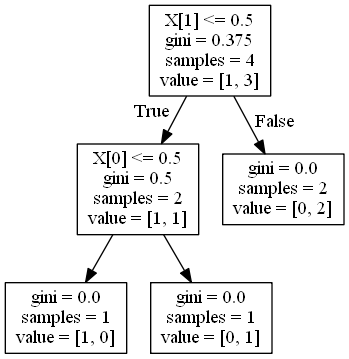

In [13]:
dot_data = export_graphviz(clf2, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [14]:
#importing Iris dataset from sklearn datasets
from sklearn import datasets
iris=datasets.load_iris()
X=iris.data[:,:]
Y=iris.target
for i in range(len(X)):
    for j in range(len(X[0])):
        X[i][j]=int(X[i][j])

clf3 = DTree() 
clf3.fit(X,Y)

Level 0
Count of 0 = 50
Count of 1 = 50
Count of 2 = 50
Current Entropy is = 1.584962500721156
Splitting on feature  X[3] with gain ratio 0.7815267586841398
Level 1
Count of 0 = 50
Count of 1 = 0
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 50
Count of 2 = 21
Current Entropy is = 0.8760643678555244
Splitting on feature  X[2] with gain ratio 0.2904563258533921
Level 2
Count of 0 = 0
Count of 1 = 11
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 37
Count of 2 = 5
Current Entropy is = 0.5266170655714282
Splitting on feature  X[0] with gain ratio 0.12090521282362249
Level 3
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 15
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 21
Count of 2 = 4
Current Entropy is = 0.6343095546405662
Splitting on feature  X[1] with gain rat

In [15]:
Y_pred3 = clf3.predict(X)
print("Predictions : ",Y_pred3)
print()
our_score = clf3.score(X,Y)
#score on training data
print("Score :",our_score) 
print()

Predictions :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]

Score : 0.96



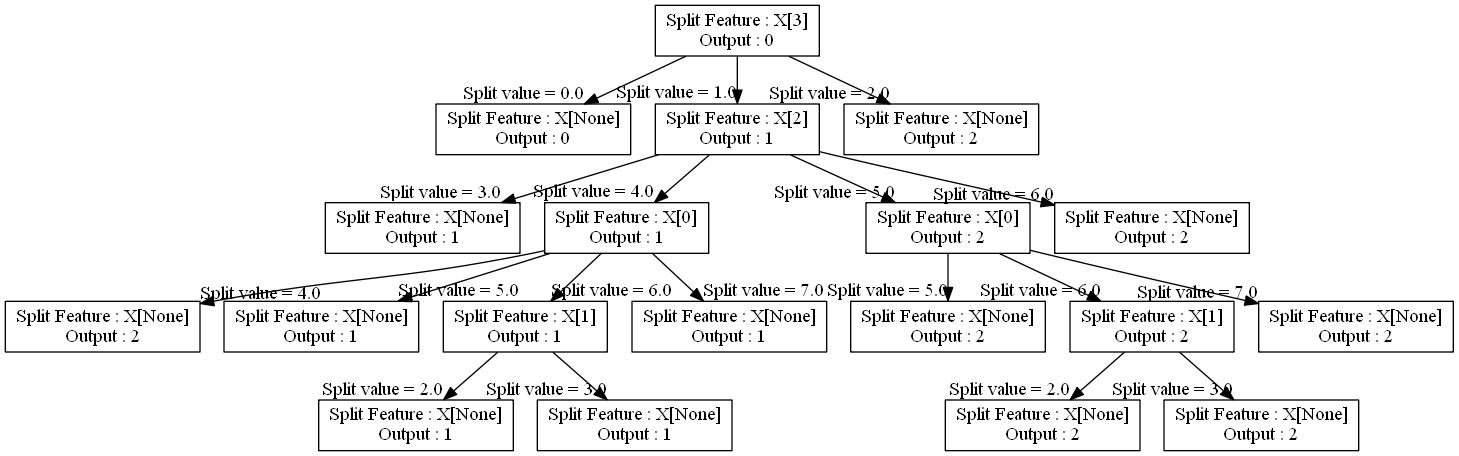

In [17]:
dot_data=clf3.export_tree(filename="iris.pdf")
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [18]:
#Using the inbuilt sklearn Decision tree and comparing it with our model on the same dataset
import sklearn.tree
clf4 = sklearn.tree.DecisionTreeClassifier()
clf4.fit(X,Y)
Y_pred4 = clf4.predict(X)
print("Predictions",Y_pred4)
sklearn_score = clf4.score(X,Y)

#comparing scores
print("Score of our model :",our_score)
print("Score of inbuilt sklearn's decision tree on the same data :",sklearn_score)

Predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]
Score of our model : 0.96
Score of inbuilt sklearn's decision tree on the same data : 0.96


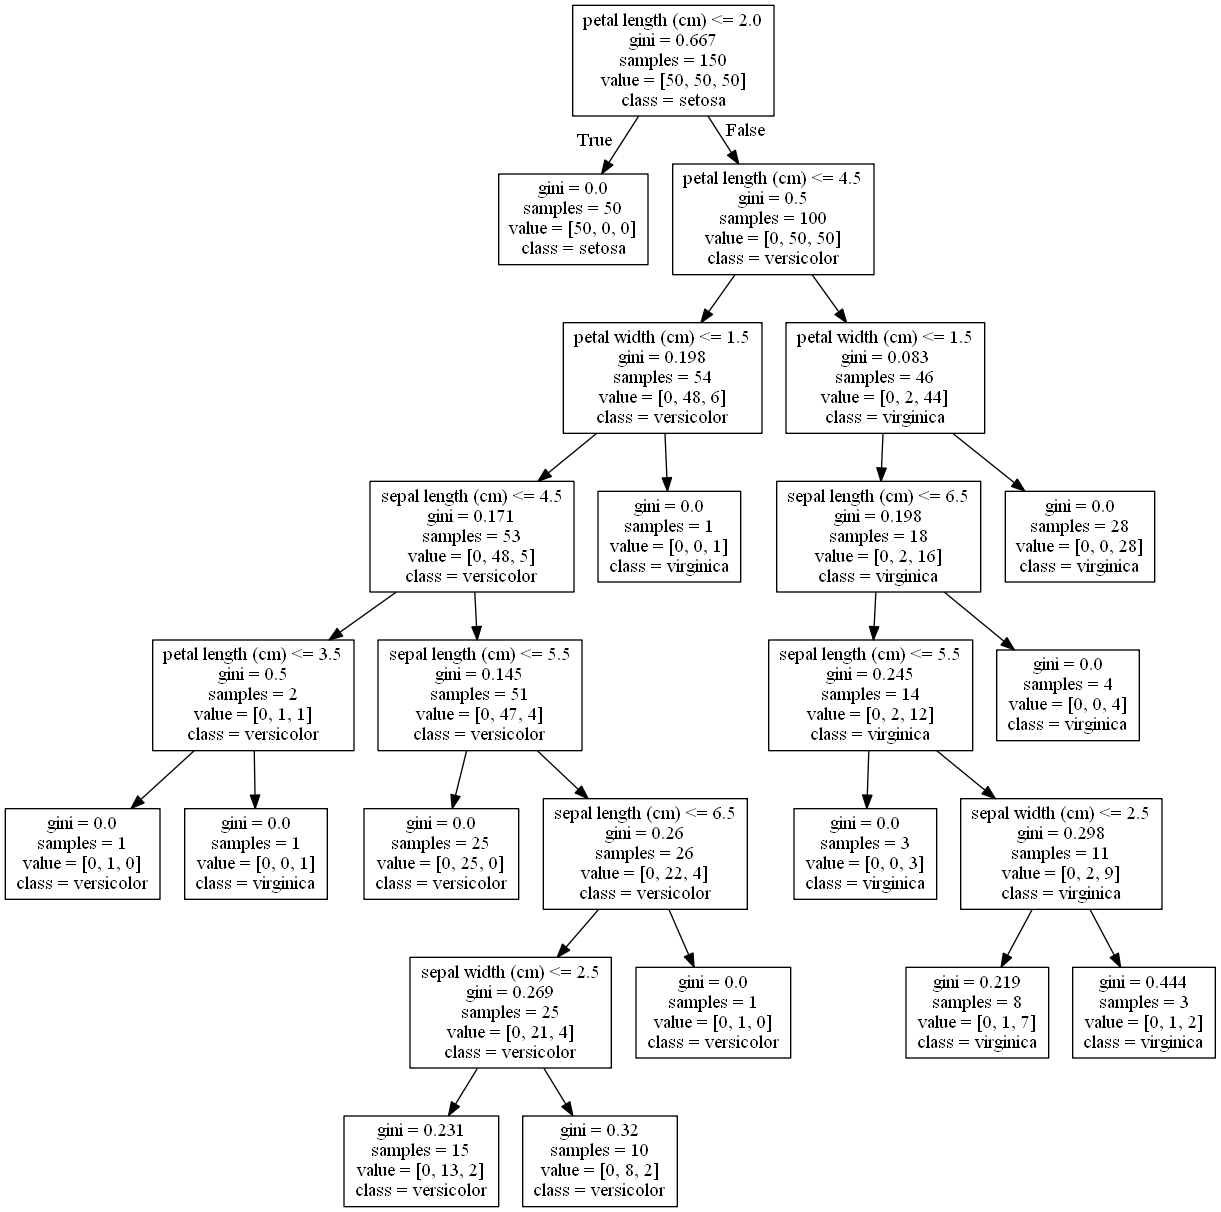

In [19]:
dot_data = export_graphviz(clf4, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())